In [1]:
import numpy as np
import torch
from ppflows.dequantization import DequantizationUniform, DequantizationBeta
from matplotlib import pyplot as plt

In [2]:
n = 50000000
d_continuous = 4
data_continuous = torch.rand(n, d_continuous)

In [3]:
'''
categorical_1 = torch.distributions.Categorical(torch.Tensor([0.6, 0.4]))
data_categorical = categorical_1.sample(torch.Size([n])).long()[...,None]
num_categories_per_dim = torch.Tensor([torch.max(data_categorical)])+1
'''

'\ncategorical_1 = torch.distributions.Categorical(torch.Tensor([0.6, 0.4]))\ndata_categorical = categorical_1.sample(torch.Size([n])).long()[...,None]\nnum_categories_per_dim = torch.Tensor([torch.max(data_categorical)])+1\n'

In [4]:
categorical_1 = torch.distributions.Categorical(torch.Tensor([0.3, 0.2, 0.1, 0.4]))
categorical_2 = torch.distributions.Categorical(torch.Tensor([0.1, 0.1, 0.1, 0.3, 0.1, 0.3]))
data_categorical_1 = categorical_1.sample(torch.Size([n])).long()
data_categorical_2 = categorical_2.sample(torch.Size([n])).long()
data_categorical = torch.stack((data_categorical_1, data_categorical_2), dim=-1)
num_categories_per_dim = torch.Tensor([torch.max(data_categorical_1), torch.max(data_categorical_2)]).long() + 1

In [5]:
dequantization = DequantizationBeta(num_categories_per_dim, d_continuous)

In [6]:
with torch.no_grad():
    data_dequantized, log_probs_forward  = dequantization.forward(data_continuous, data_categorical)
    data_requantized_continuous, data_requantized_categorical, log_probs_backward = dequantization.inverse(data_dequantized)

torch.Size([10000000, 2])
torch.Size([10000000])
torch.Size([10000000, 2])
torch.Size([10000000])


In [7]:
print("Difference continuous data", ~(data_continuous - data_requantized_continuous == 0.).any())
print("Difference discrete data", ~(data_categorical - data_requantized_categorical == 0).any())
print("Difference log probs", ~(log_probs_forward + log_probs_backward == 0).any())

Difference continuous data tensor(False)
Difference discrete data tensor(False)
Difference log probs tensor(False)


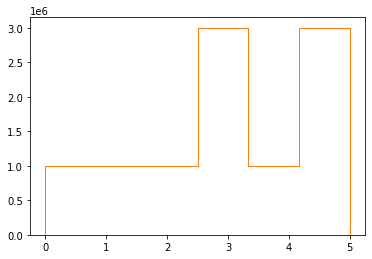

In [8]:
plt.hist(data_categorical.numpy()[:,1], bins=6, histtype='step')
plt.hist(data_requantized_categorical.numpy()[:,1], bins=6, histtype='step')
# plt.hist(data_categorical.numpy()[:,0], bins=2, histtype='step')
# plt.hist(data_requantized_categorical.numpy()[:,0], bins=2, histtype='step')
plt.show()

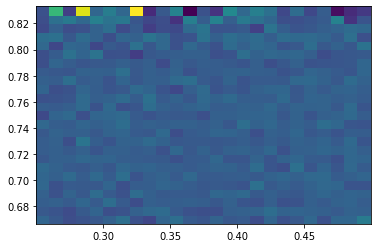

In [11]:
# Select a category and check conditional log prob
category_now = torch.Tensor([1, 4]).long()
mask = (torch.sum(data_categorical == category_now, dim=-1) == 2)
# category_now = torch.Tensor([1])
# mask = (data_categorical == category_now).squeeze()
data_now = data_categorical[mask]
data_dequantized_now = data_dequantized[mask]
log_probs_forward_now = log_probs_forward[mask]

plt.hist2d(data_dequantized_now[:,4].numpy(), data_dequantized_now[:,5].numpy(), weights=(torch.exp(log_probs_forward_now)).numpy(), bins=25)
# plt.hist2d(data_dequantized_now[:,4].numpy(), data_dequantized_now[:,5].numpy(), bins=25)
plt.show()